# Quantized latent with inverse model on continuous maze

## Instanciate and train the model

Create the environment.

In [1]:
import gym
from go_explore.utils import AtariWrapper

env = gym.make("ALE/PrivateEye-v5")
env = AtariWrapper(env)

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


In [2]:
from PIL import Image
import numpy as np

env.reset()
obs, rew, done, info = env.step(env.action_space.sample())
im = np.hstack((obs[:, :, 0:3], obs[:, :, 3:6], obs[:, :, 6:9], obs[:, :, 9:12]))
im = Image.fromarray(im)

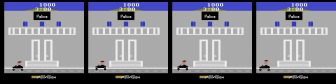

In [3]:
from IPython.display import display

display(im)

Initilize the device.

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [5]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.vec_env import VecTransposeImage

buffer = ReplayBuffer(10_000, VecTransposeImage.transpose_space(env.observation_space), env.action_space, device=device)

for episode in range(10):
    done = False
    obs = VecTransposeImage.transpose_image(env.reset())
    while not done:
        action = np.array(env.action_space.sample())
        next_obs, reward, done, info = env.step(action)
        next_obs = VecTransposeImage.transpose_image(next_obs)
        buffer.add(obs, next_obs, action, reward, done, [info])
        obs = next_obs

Instanciate the model and the optimizer.

In [6]:
from go_explore.inverse_model import ConvInverseModel

from torch import optim

inverse_model = ConvInverseModel(action_size=env.action_space.n, latent_size=32)
optimizer = optim.Adam(inverse_model.parameters(), lr=1e-3)

Train the model.

In [7]:
print(buffer.pos)

6740


In [8]:
import torch.nn.functional as F


for epoch in range(500):
    # Sample
    sample = buffer.sample(32)
    observations = sample.observations.float() / 255
    next_observations = sample.next_observations.float() / 255
    actions = sample.actions

    # Compute the output image
    inverse_model.train()
    pred_actions = inverse_model(observations, next_observations)

    # Compute the loss
    loss = F.cross_entropy(pred_actions, actions.squeeze())

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print("epoch: {:5d}\tprediction loss: {:.5f}".format(epoch, loss.item()))

epoch:     0	prediction loss: 2.90148
epoch:    50	prediction loss: 2.89600
epoch:   100	prediction loss: 2.91478
epoch:   150	prediction loss: 2.89523
epoch:   200	prediction loss: 2.85163
epoch:   250	prediction loss: 2.34538
epoch:   300	prediction loss: 2.09546
epoch:   350	prediction loss: 2.04205
epoch:   400	prediction loss: 2.00437
epoch:   450	prediction loss: 1.91180


See the result for one transition.

In [9]:
from go_explore.utils import ATARI_ACTIONS

# Sample one transition
sample = buffer.sample(1)
observations = sample.observations.float() / 255
next_observations = sample.next_observations.float() / 255
actions = sample.actions.item()

# Predict the action
inverse_model.eval()
pred_actions = inverse_model(observations, next_observations)

# See the result
print("true action\t\t", ATARI_ACTIONS[actions])
print("predicted action\t", ATARI_ACTIONS[pred_actions.argmax().item()])

true action		 UPRIGHTFIRE
predicted action	 DOWNRIGHT


## Quantizing the latent

Sample and compute the latent.

In [11]:
# Sample a batch of transitions
sample = buffer.sample(512)
observations = sample.observations.float() / 255

# Get the latent and quantized it
inverse_model.eval()
latent = inverse_model.encoder(observations)

Quantize.

In [12]:
quantized = torch.round(latent, decimals=0) + 0.0  # +0.0 to avoid -0.0
quantized = quantized.detach().cpu().numpy()

Represent the observations and the corresponding quantized latent .

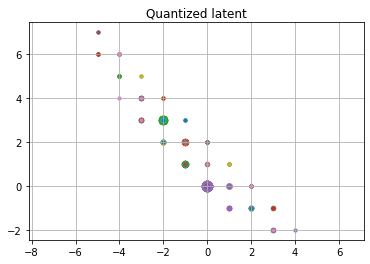

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots()

cells, counts = np.unique(quantized, return_counts=True, axis=0)

# Quantized latent
axs.grid()
axs.set_title("Quantized latent")
axs.axis("equal")
for cell, count in zip(cells, counts):
    axs.scatter(*quantized[(quantized == cell).all(1)].T[:2], s=count * 10)

The bigger the circle, the more observations in the cell.